In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


import gc


df = pd.read_csv('./output/train.csv')


In [2]:
df.isna().sum(axis=1)
print(len(df))
df = df.dropna(axis=0)
print(len(df))

# no games from 2011 bc they have nans
with pd.option_context('mode.use_inf_as_na', True):
    df = df.fillna(0)
    

106368
84568


In [3]:

print(df.shape)

(84568, 57)


In [4]:
to_drop = ['Sea_TO_x','Sea_TO_y','Sea_FT_x','Sea_FT_y','Sea_PF_x','Sea_PF_y']

df = df.drop(columns=to_drop)

y = df.target
X = df.drop(columns=['target'])

In [5]:
scaler = StandardScaler()
cat = []
num = [i for i in list(df)]

df[num] = scaler.fit_transform(df[num])

In [6]:


# using LGBM gain
# to_drop = ['Sea_FT_x','Sea_FT_y','wSea_OReb_x','wSea_OReb_y','wSea_2pt_x','wSea_2pt_y','wSea_3pt_x','wSea_3pt_y']
# X = X.drop(columns=to_drop)


In [7]:
from lofo import LOFOImportance, Dataset, plot_importance

# extract a sample of the data
sample_df = df.sample(frac=1, random_state=0)

# define the validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=0)

dataset = Dataset(df=sample_df, target="target", features=[col for col in df.columns if col != "target"])

In [8]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, model= model_lgb, cv=cv, scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
# plot_importance(importance_df, figsize=(12, 20))


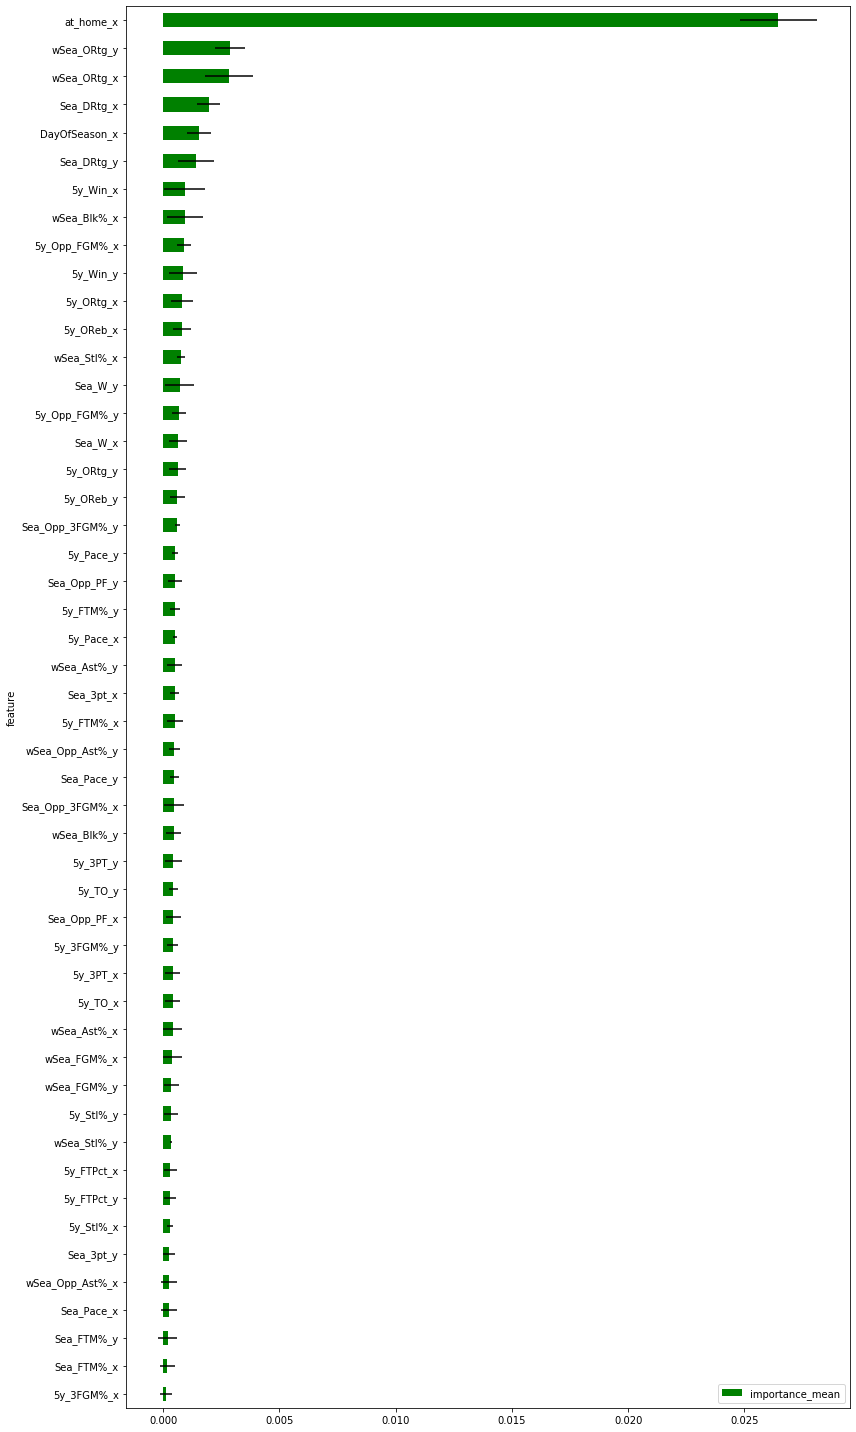

In [9]:
figsize = (12,20)
importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
importance_df.sort_values("importance_mean", inplace=True)
importance_df.plot(x="feature", y="importance_mean", xerr="importance_std", kind='barh', color=importance_df["color"], figsize=figsize)
plt.tight_layout()
plt.savefig('./figures/lofo_importance4.png')


In [10]:


# colormap = plt.cm.RdBu
# plt.figure(figsize=(14,14))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, cmap=colormap, linecolor='white', annot=False)



In [11]:
#Validation function
n_folds = 5

feat_names = list(X)

def mae_cv(model, lin_reg=False):

    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator=True)
    all_estimators = []
    for idx,estimator in enumerate(output['estimator']):
        if lin_reg:
            all_estimators.append(list(estimator.coef_))
        else:  
            all_estimators.append(list(estimator.feature_importances_))
    
    all_estimators = pd.DataFrame(all_estimators)
    avg_imp = all_estimators.values.mean(axis=0)
    feature_importances = pd.DataFrame(avg_imp, index = feat_names,
                                       columns=['importance']).sort_values('importance', ascending=False)
    
    feature_importances = feature_importances.reset_index()
    feature_importances.columns = ['feats','importance']
#     print(feature_importances)
    return output, feature_importances



Lin_Reg score: 9.1749 (0.1207)



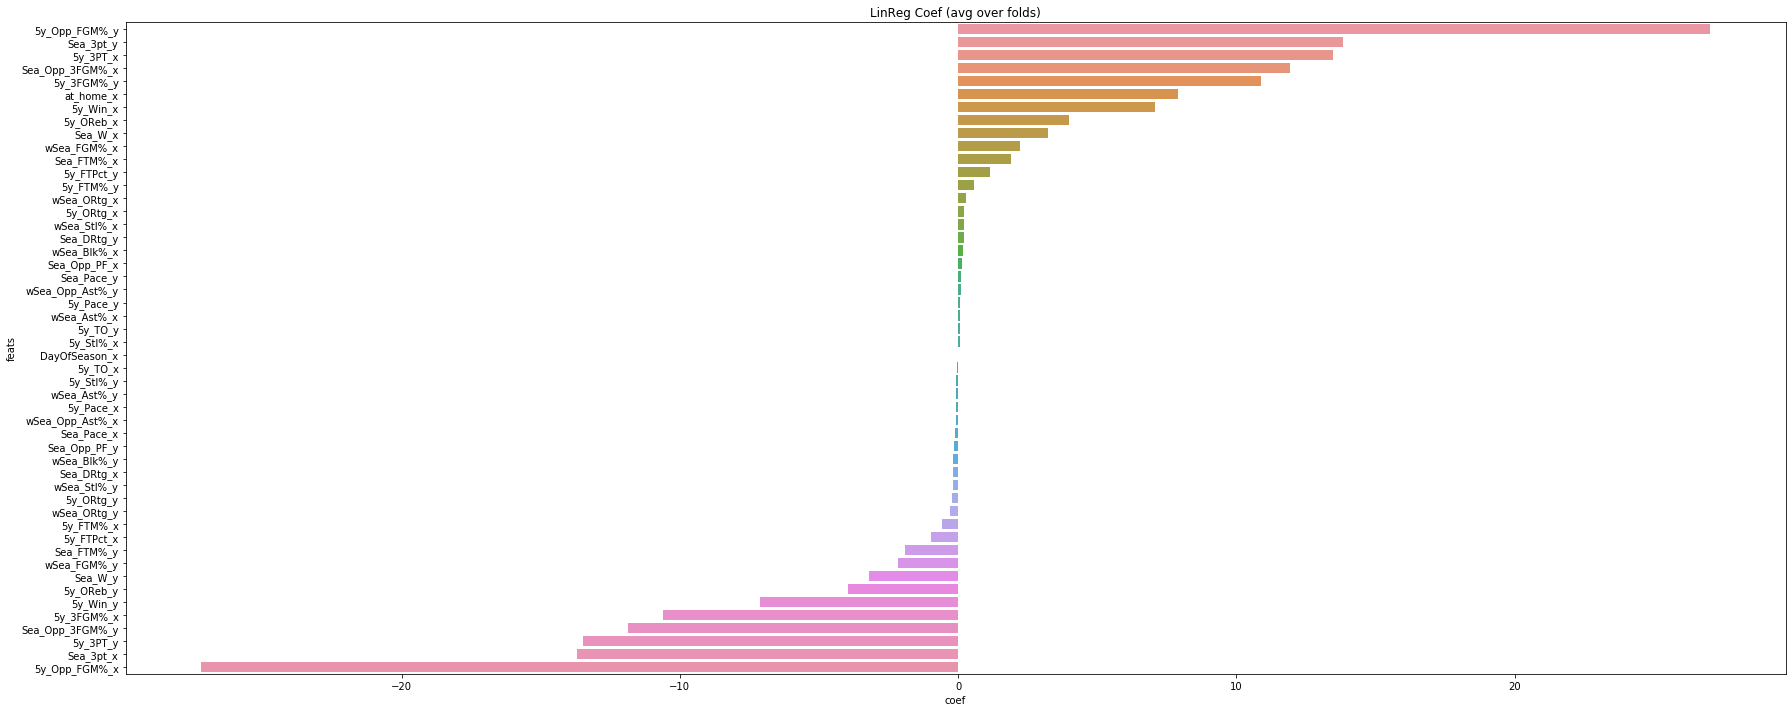

In [12]:
lin_reg = LinearRegression()

output, feat_imp = mae_cv(lin_reg, lin_reg=True)
print("Lin_Reg score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))
# print(output['test_score'])
plt.figure(figsize=(25, 10))

sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LinReg Coef (avg over folds)')
plt.xlabel('coef')
plt.tight_layout()
plt.savefig('./figures/linreg_importances-03.png')
plt.show()

In [13]:
# score = mae_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 9.0919 (0.1094)



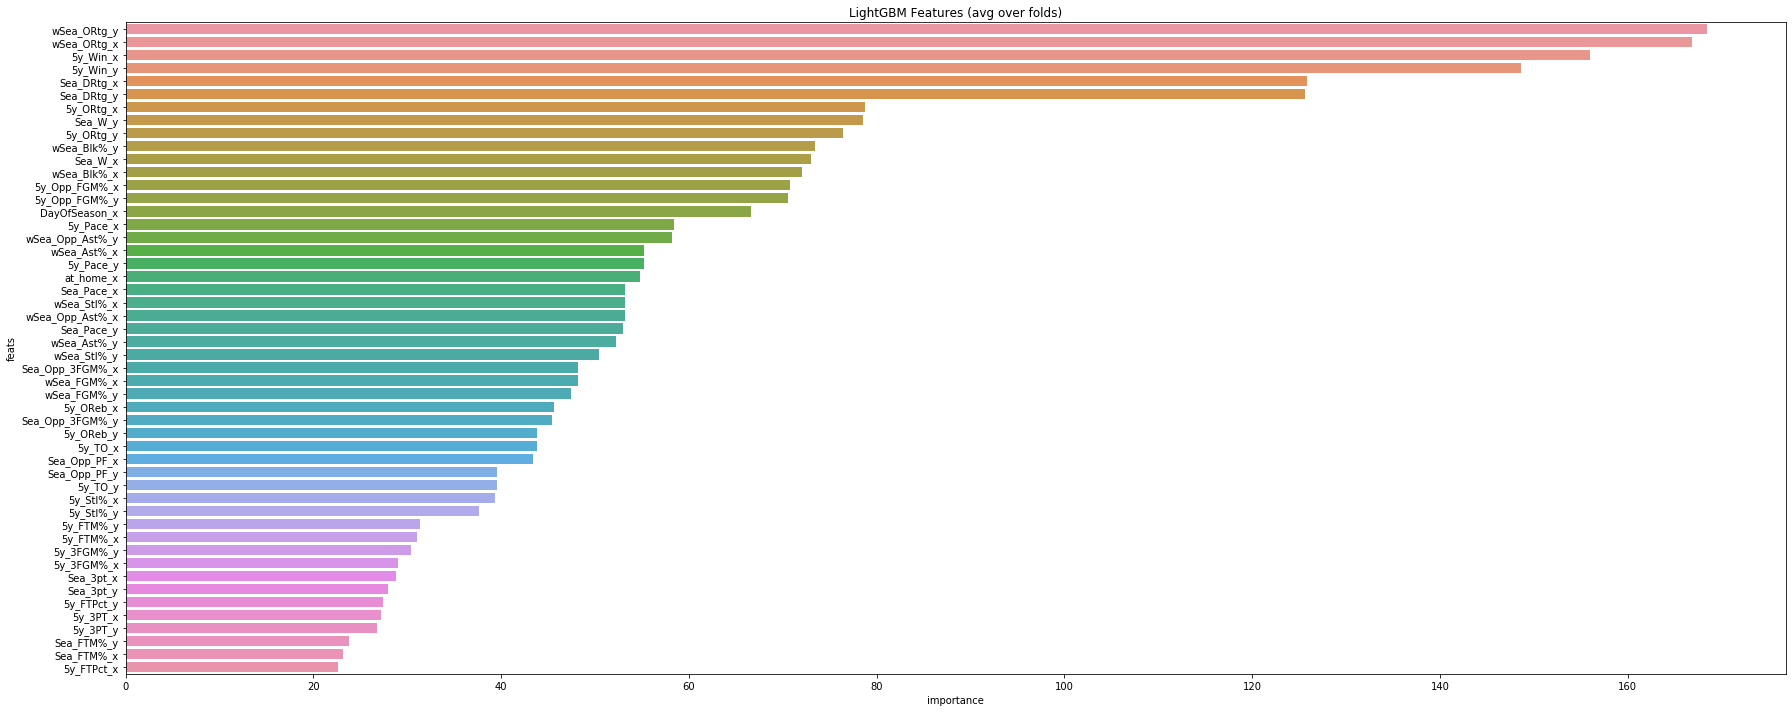

In [14]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

output, feat_imp = mae_cv(model_lgb)
# dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])



# rekord 
# LGBM score: 9.0919 (0.1094)


print("LGBM score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))
sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('./figures/lgbm_importances-03.png')
plt.show()


In [15]:
print(list(feat_imp.feats))


['wSea_ORtg_y', 'wSea_ORtg_x', '5y_Win_x', '5y_Win_y', 'Sea_DRtg_x', 'Sea_DRtg_y', '5y_ORtg_x', 'Sea_W_y', '5y_ORtg_y', 'wSea_Blk%_y', 'Sea_W_x', 'wSea_Blk%_x', '5y_Opp_FGM%_x', '5y_Opp_FGM%_y', 'DayOfSeason_x', '5y_Pace_x', 'wSea_Opp_Ast%_y', 'wSea_Ast%_x', '5y_Pace_y', 'at_home_x', 'Sea_Pace_x', 'wSea_Stl%_x', 'wSea_Opp_Ast%_x', 'Sea_Pace_y', 'wSea_Ast%_y', 'wSea_Stl%_y', 'Sea_Opp_3FGM%_x', 'wSea_FGM%_x', 'wSea_FGM%_y', '5y_OReb_x', 'Sea_Opp_3FGM%_y', '5y_OReb_y', '5y_TO_x', 'Sea_Opp_PF_x', 'Sea_Opp_PF_y', '5y_TO_y', '5y_Stl%_x', '5y_Stl%_y', '5y_FTM%_y', '5y_FTM%_x', '5y_3FGM%_y', '5y_3FGM%_x', 'Sea_3pt_x', 'Sea_3pt_y', '5y_FTPct_y', '5y_3PT_x', '5y_3PT_y', 'Sea_FTM%_y', 'Sea_FTM%_x', '5y_FTPct_x']


# Now for neural network


In [16]:
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold

ModuleNotFoundError: No module named 'keras'

In [ ]:
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def get_model():
    x = keras.layers.Input(shape=[X.shape[1]])
    fc1 = keras.layers.Dense(units=450, input_shape=[X.shape[1]])(x)
    act1 = keras.layers.PReLU()(fc1)
    bn1 = keras.layers.BatchNormalization()(act1)
    dp1 = keras.layers.Dropout(0.45)(bn1)
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    concat1 = keras.layers.Concatenate()([x, gn1])
    fc2 = keras.layers.Dense(units=600)(concat1)
    act2 = keras.layers.PReLU()(fc2)
    bn2 = keras.layers.BatchNormalization()(act2)
    dp2 = keras.layers.Dropout(0.45)(bn2)
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.45)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    output = keras.layers.Dense(units=1)(concat2)
    model = keras.models.Model(inputs=[x], outputs=[output])
    return model


def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss='mean_absolute_error')
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
    return model


In [ ]:
X = X.values
y = y.values


In [ ]:

rkf = RepeatedKFold(n_splits=5, n_repeats=5)
batch_size = 64
models = []

for tr_idx, vl_idx in rkf.split(X, y):
    
    x_tr, y_tr = X[tr_idx], y[tr_idx]
    x_vl, y_vl = X[vl_idx], y[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='./figures/model_plot.png', show_shapes=True, show_layer_names=True)